# Challenge - Gradient Boost

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

#### Improve:

Training set accuracy:
1. Percent Type I errors: 0.04650845608292417
2. Percent Type II errors: 0.17607746863066012

Test set accuracy:
1. Percent Type I errors: 0.06257668711656442
2. Percent Type II errors: 0.18527607361963191

Score
1. 0.75214723926380367

In [7]:
#Imports

import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split


In [3]:
#Data Import
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()
df.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0


### EDA

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8147 entries, 0 to 8593
Data columns (total 13 columns):
cntry      8147 non-null object
idno       8147 non-null float64
year       8147 non-null int64
tvtot      8147 non-null float64
ppltrst    8147 non-null float64
pplfair    8147 non-null float64
pplhlp     8147 non-null float64
happy      8147 non-null float64
sclmeet    8147 non-null float64
sclact     8147 non-null float64
gndr       8147 non-null float64
agea       8147 non-null float64
partner    8147 non-null float64
dtypes: float64(11), int64(1), object(1)
memory usage: 891.1+ KB


In [4]:
df['cntry'].value_counts()

ES    2292
SE    1726
CH    1475
NO    1420
CZ    1207
DE      27
Name: cntry, dtype: int64

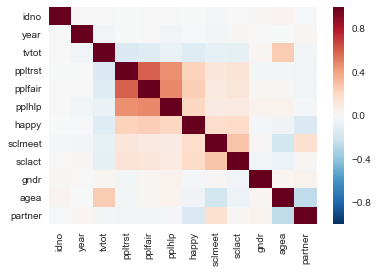

In [8]:
#Some of the items are a bit correlated. Like the pplfair and ppl trust.
sns.heatmap(df.corr())

### Feature Engineering

In [24]:
#Lets keep the same features from the excercise for now, and tune other parameters
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
#X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

In [25]:
#Check the class balance
y.value_counts()

0.0    5013
1.0    3134
Name: partner, dtype: int64

Note, skewed more towards no partners, so have to keep an eye on this and deal with the class imbalance.

In [26]:
#Will use test train split, this inheriently shuffles the data in a better way than the example
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

### Build Model

In [27]:
#Will use Grid Search to do the cross validation.

parameters = {'criterion':['friedman_mse','mse','mae']}

# Initialize the model.
clf = ensemble.GradientBoostingClassifier(max_depth=2,loss='deviance', n_estimators=800)

#Create grid and perform 5 cross validation
grid = GridSearchCV(clf, parameters, cv=5, verbose=0)

#Fit the Data
grid.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
grid.best_params_

In [15]:
predict_test = grid.predict(X_test)

# Accuracy tables.
table_test = pd.crosstab(y_test, predict_test, margins=True)

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(test_tI_errors, test_tII_errors))

Test set accuracy:
Percent Type I errors: 0.05337423312883435
Percent Type II errors: 0.17484662576687116


In [18]:
print('\n Accuracy by admission status')
print(table_test)

print('\n Percentage accuracy')
print(grid.score(X_test, y_test))


 Accuracy by admission status
col_0     0.0  1.0   All
partner                 
0.0       914   87  1001
1.0       285  344   629
All      1199  431  1630

 Percentage accuracy
0.771779141104


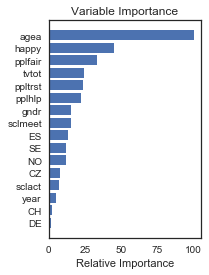

In [23]:
#Plot Feautre Importance
feature_importance = grid.best_estimator_.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()